In [12]:
class dataset_generator:
  def __init__(self, feature_dim = 1, n_sample = 100, noise = 0):
    self._feature_dim = feature_dim
    self._n_sample = n_sample
    self._noise = noise

    self._coefficient = None
    self._init_set_coefficient()

  def _init_set_coefficient(self):
    self._coefficient = [1 for _ in range(self._feature_dim)] + [0]  # weights + bias

  def set_n_sample(self, n_sample):
    self._n_sample = n_sample 

  def set_noise(self, noise):
    self._noise = noise

  def set_coefficient(self, coefficient_list):
     self._coefficient = coefficient_list

  def make_dataset(self):
    x_data = np.random.normal(0, 1, size = (self._n_sample,
                                            self._feature_dim))
    y_data = np.zeros(shape = (self._n_sample, 1))
    for feature_idx in range(self._feature_dim):
      y_data += self._coefficient[feature_idx] * x_data[:,feature_idx].reshape(-1,1)
    y_data += self._coefficient[-1] # bias
    y_data += self._noise*np.random.normal(0,1,size=(self._n_sample, 1))

    return x_data, y_data

  def dataset_visualizer(self):
    if self._feature_dim == 1:
      plt.style.use('seaborn')

      fig, ax = plt.subplots(figsize=(10,10))
      ax.plot(x_data, y_data, 'bo',
              alpha=0.3,
              markersize=20)
      ax.tick_params(axis='both',
                     labelsize=30)
      ax.set_title("Dataset", fontsize=40, color='darkred')
      ax.set_xlabel('X data', fontsize=30, alpha=0.6)
      ax.set_ylabel('Y data', fontsize=30, alpha=0.6)

    else:
      class feature_dim_error(Exception):
        pass
      raise feature_dim_error("Visualization is valid for only feature_dim == 1")

In [7]:
# basic_nodes
class plus_node:
  def __init__(self):
    self._x, self._y = None, None
    self._z = None
  
  def forward(self,x,y):
    self._x, self._y = x, y
    self._z = self._x + self._y
    return self._z
  
  def backward(self, dz): # dz = dJ/dz
    return dz*1,dz*1 #dJ/dx= dJ/dz * dz/dx, dJ/dy

class minus_node:
  def __init__(self):
    self._x, self._y = None, None
    self._z = None

  def forward(self, x, y):
    self._x, self._y = x, y
    self._z = self._x - self._y
    return self._z

  def backward(self, dz):
    return 1*dz, -1*dz

class mul_node:
  def __init__(self):
    self._x, self._y = None, None
    self._z = None

  def forward(self, x, y):
    self._x , self._y = x, y
    self._z = self._x * self._y
    return self._z

  def backward(self, dz):
    return dz*self._y, dz*self._x # dJ/dz * dz/dx, dJ/dy

class square_node:
  def __init__(self):
    self._x = None
    self._z = None

  def forward(self, x):
    self._x = x
    self._z = self._x * self._x
    return self._z

  def backward(self, dz):
    return dz*(2*self._x)

class mean_node:
  def __init__(self):
    self._x = None
    self._z = None

  def forward(self, x):
    self._x = x
    self._z = np.mean(self._x) # z = 1/n *(x1+x2+...+xn)
    return self._z

  def backward(self, dz):
    dx = dz*1/len(self._x)*np.ones_like(self._x) # dJ/dx1 = dJ/dz * dz/dx1 = dJ/dz * (1/n)
    return dx

# Stochastic Gradient Descent

### Initial Setting

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as sm

np.random.seed(0)
plt.style.use('seaborn')

In [5]:
# Dataset Preparation
dataset_gen = dataset_generator()
dataset_gen.set_coefficient([5,0])
x_data, y_data = dataset_gen.make_dataset()

### Model/Loss Setting

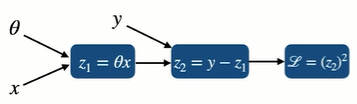

In [9]:
# model part
node1 = mul_node()

# square error loss part
node2 = minus_node()
node3 = square_node()

## Learning without Replacement

In [17]:
th = -1
lr = 0.01
loss_list, th_list= [], []
epochs = 2

for epoch in range(epochs):
  # 랜덤 셔플링
  random_idx = np.arange(len(x_data)) # 0~99까지의 array
  np.random.shuffle(random_idx) 
  x_data = x_data[random_idx]
  y_data = y_data[random_idx]

  for data_idx in range(len(x_data)):
    x, y = x_data[data_idx], y_data[data_idx]

    # forward propagation
    z1 = node1.forward(th,x)
    z2 = node2.forward(y,z1)
    L = node3.forward(z2)

    # backward propagation
    dz2 = node3.backward(1)
    dy, dz1 = node2.backward(dz2)
    dth, dx = node1.backward(dz1)

    # update
    th = th - lr*dth

    # for tracking
    th_list.append(th.item())
    loss_list.append(L.item())

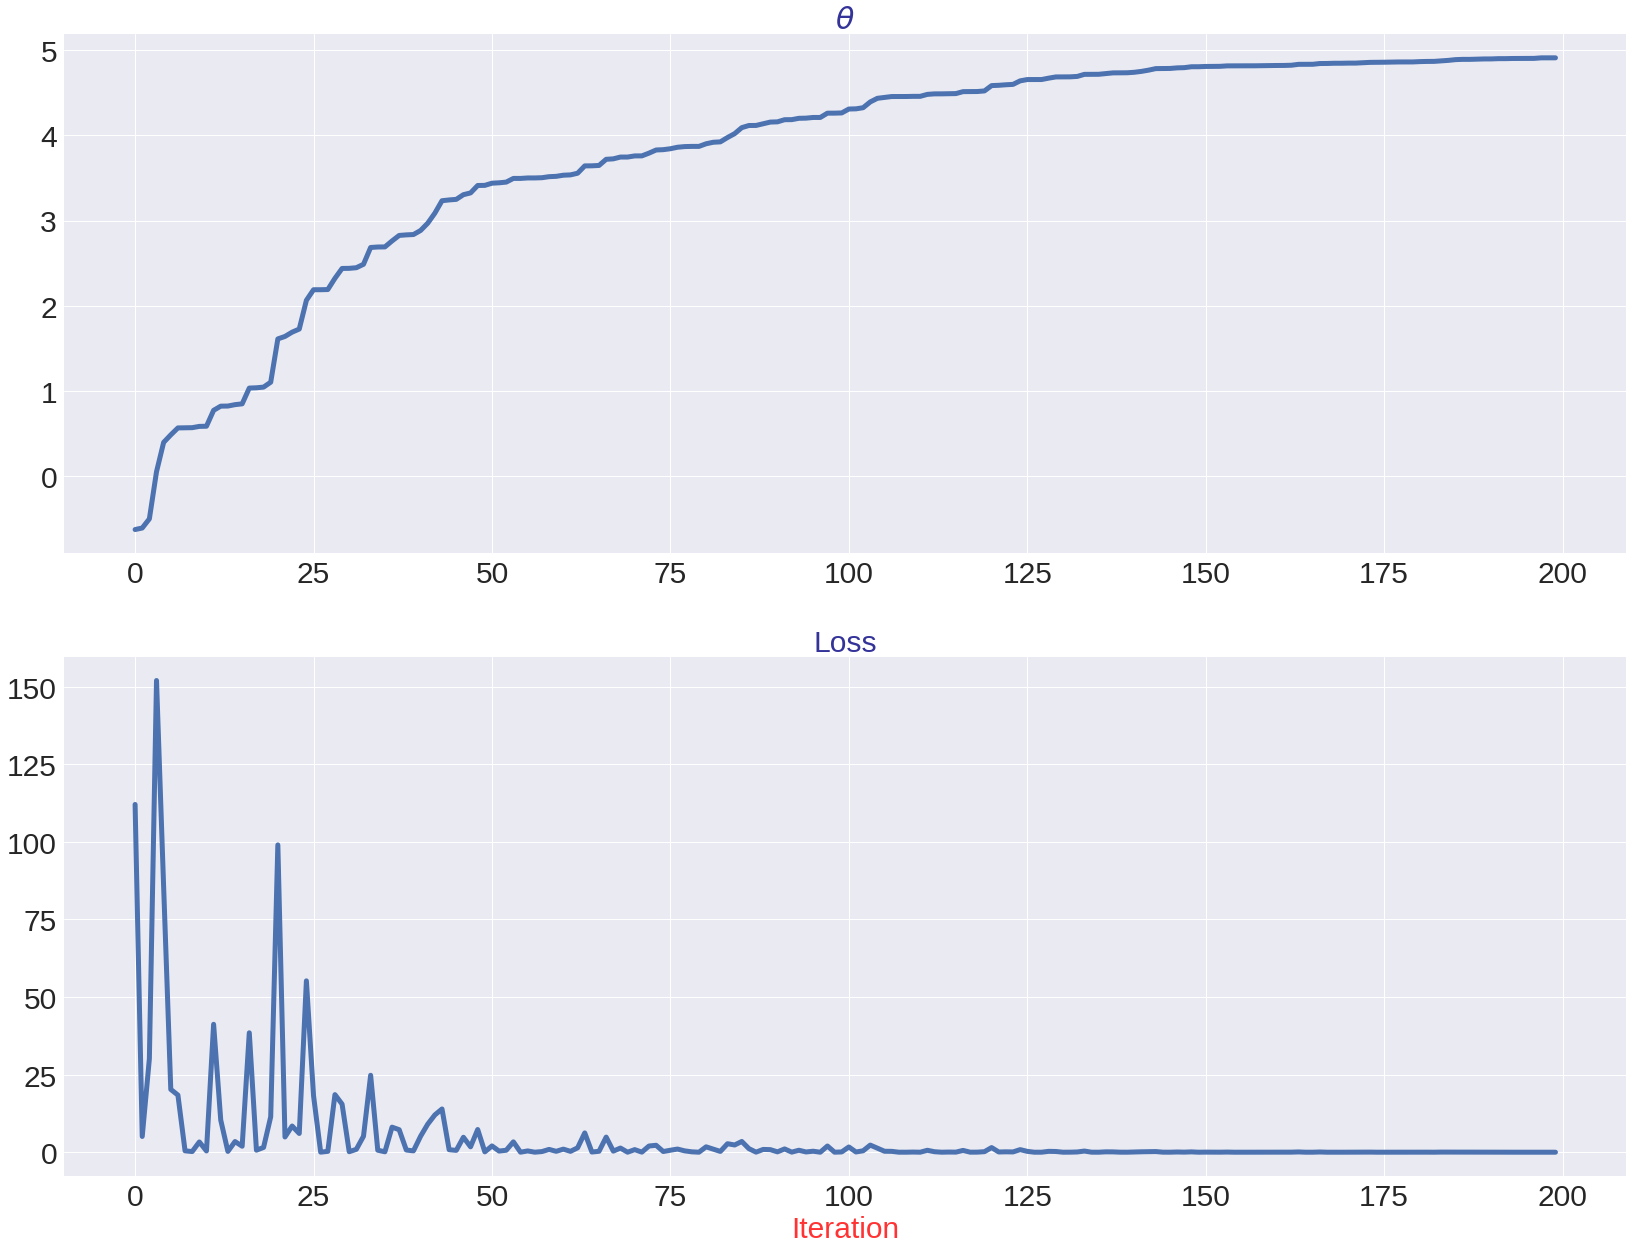

In [15]:
fig, ax = plt.subplots(2,1, figsize=(28, 21))
ax[0].plot(th_list, linewidth = 5)
ax[1].plot(loss_list, linewidth = 5)
title_font = {'size':30, 'alpha':0.8, 'color':'navy'}
label_font = {'size':30, 'alpha':0.8}

ax[0].set_title(r'$\theta$', fontdict = title_font)
ax[1].set_title('Loss', fontdict = title_font)
ax[1].set_xlabel("Iteration", color='red', fontdict = label_font)
ax[0].tick_params(axis='both', which='major', labelsize=30)
ax[1].tick_params(axis='both', which='major', labelsize=30)

## Learning with Replacement

In [18]:
th = -1
lr = 0.01
loss_list, th_list = [], []
iterations = 200 # 데이터셋 전부 보는것이 아니기 떄문에 epoch보다 iteration이라고 표현

for _ in range(iterations):
  # 랜덤 셔플링
  idx_arr = np.arange(len(x_data)) # 0~99 array
  random_idx = np.random.choice(idx_arr, 1) # array중 하나만 뽑음

  x, y = x_data[random_idx], y_data[random_idx]

  # forward propagation
  z1 = node1.forward(th, x)
  z2 = node2.forward(y, z1)
  L = node3.forward(z2)

  # backward propagation
  dz2 = node3.backward(1)
  dy, dz1 = node2.backward(dz2)
  dth, dx = node1.backward(dz1)

  # update
  th = th - lr*dth

  # for tracking
  loss_list.append(L.item())
  th_list.append(th.item())

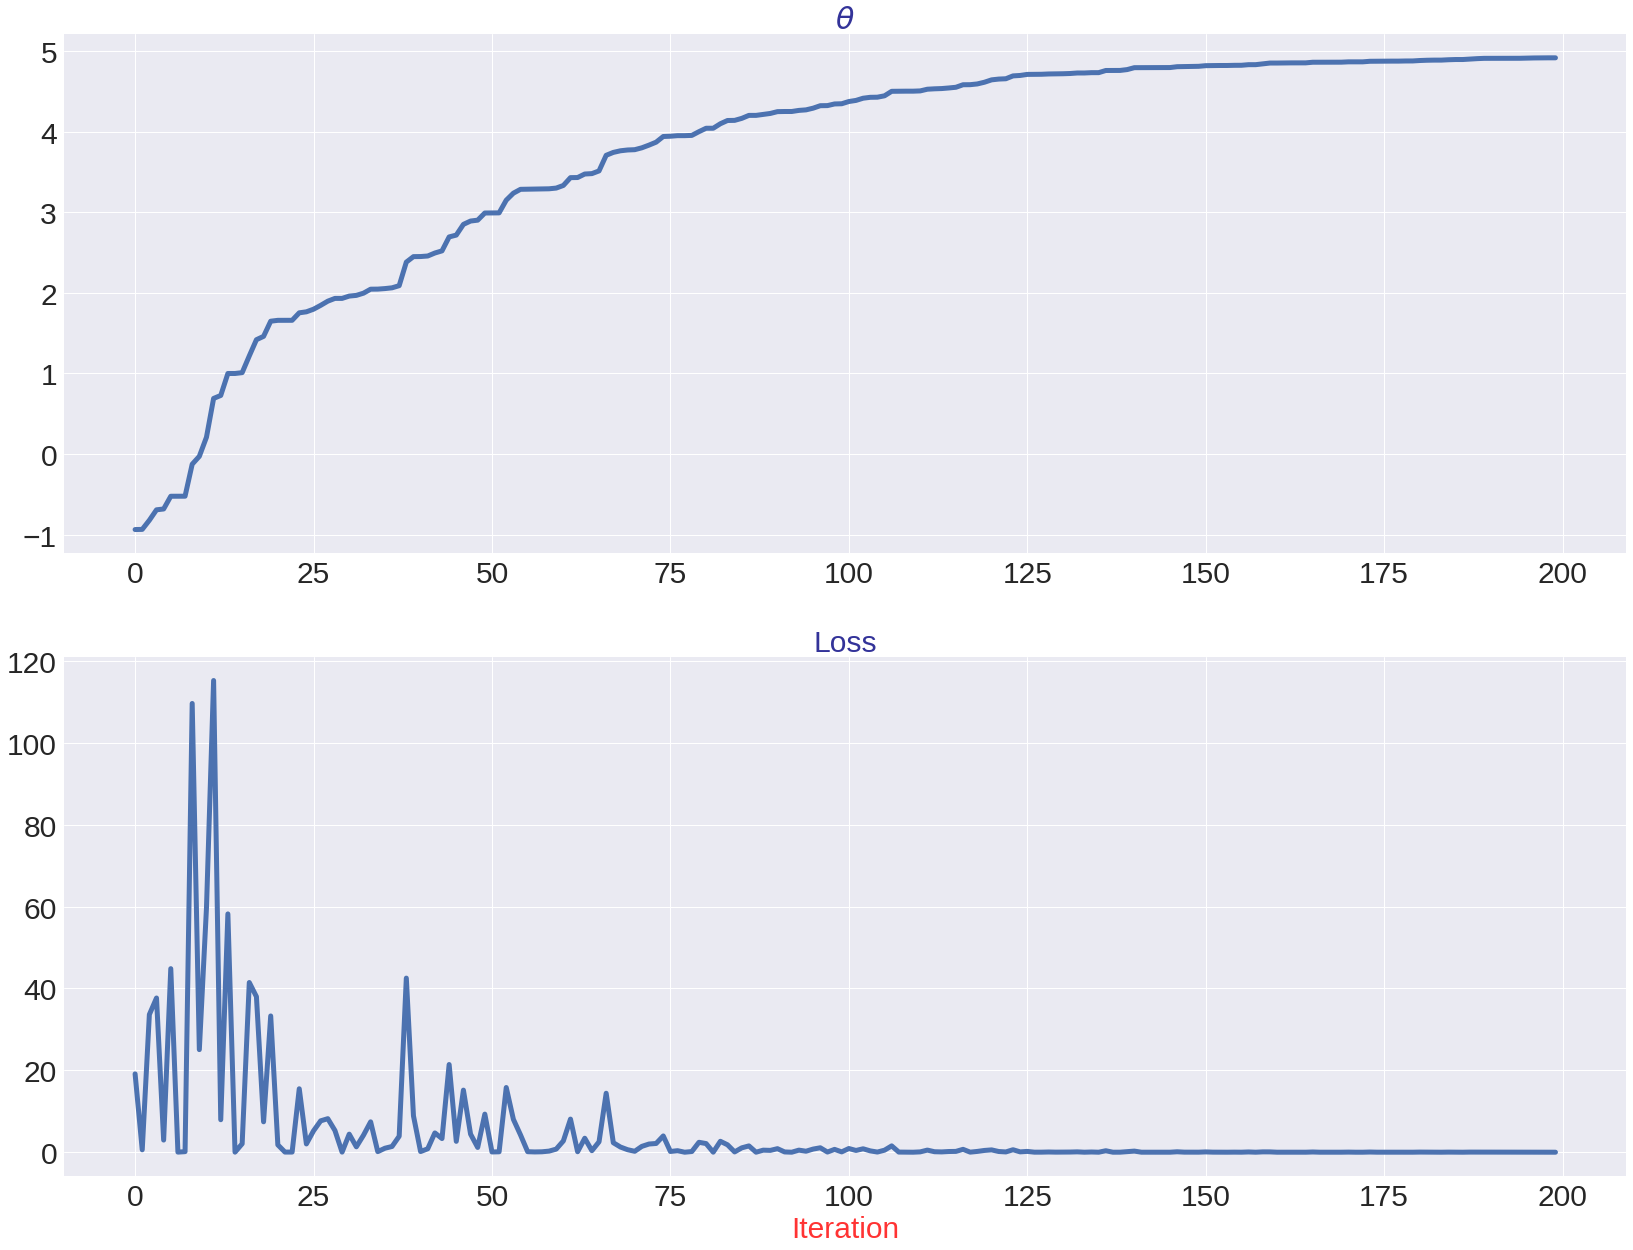

In [19]:
fig, ax = plt.subplots(2,1, figsize=(28, 21))
ax[0].plot(th_list, linewidth = 5)
ax[1].plot(loss_list, linewidth = 5)
title_font = {'size':30, 'alpha':0.8, 'color':'navy'}
label_font = {'size':30, 'alpha':0.8}

ax[0].set_title(r'$\theta$', fontdict = title_font)
ax[1].set_title('Loss', fontdict = title_font)
ax[1].set_xlabel("Iteration", color='red', fontdict = label_font)
ax[0].tick_params(axis='both', which='major', labelsize=30)
ax[1].tick_params(axis='both', which='major', labelsize=30)

# Batch Gradient Descent

### Model/Cost Setting

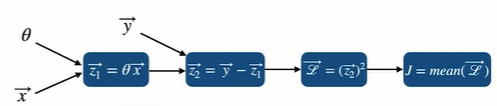

In [20]:
# model part
node1 = mul_node()

# square error loss / MSE cost part
node2 = minus_node()
node3 = square_node()
node4 = mean_node()

In [21]:
th = -1
lr = 0.01
cost_list, th_list = [], []
epochs = 200 # batch gradient에서는 epoch이 iteration과 동일

for _ in range(epochs):
  X, Y = x_data, y_data # 데이터를 그대로 가져옴

  # forward propagation
  Z1 = node1.forward(th, X)
  Z2 = node2.forward(Y, Z1)
  L = node3.forward(Z2)
  J = node4.forward(L)

  # backward propagation
  dL = node4.backward(1)
  dZ2 = node3.backward(dL)
  dY, dZ1 = node2.backward(dZ2)
  dTh, dX = node1.backward(dZ1)

  # update
  th = th - lr*np.sum(dTh)

  # for tracking
  th_list.append(th)
  cost_list.append(J)

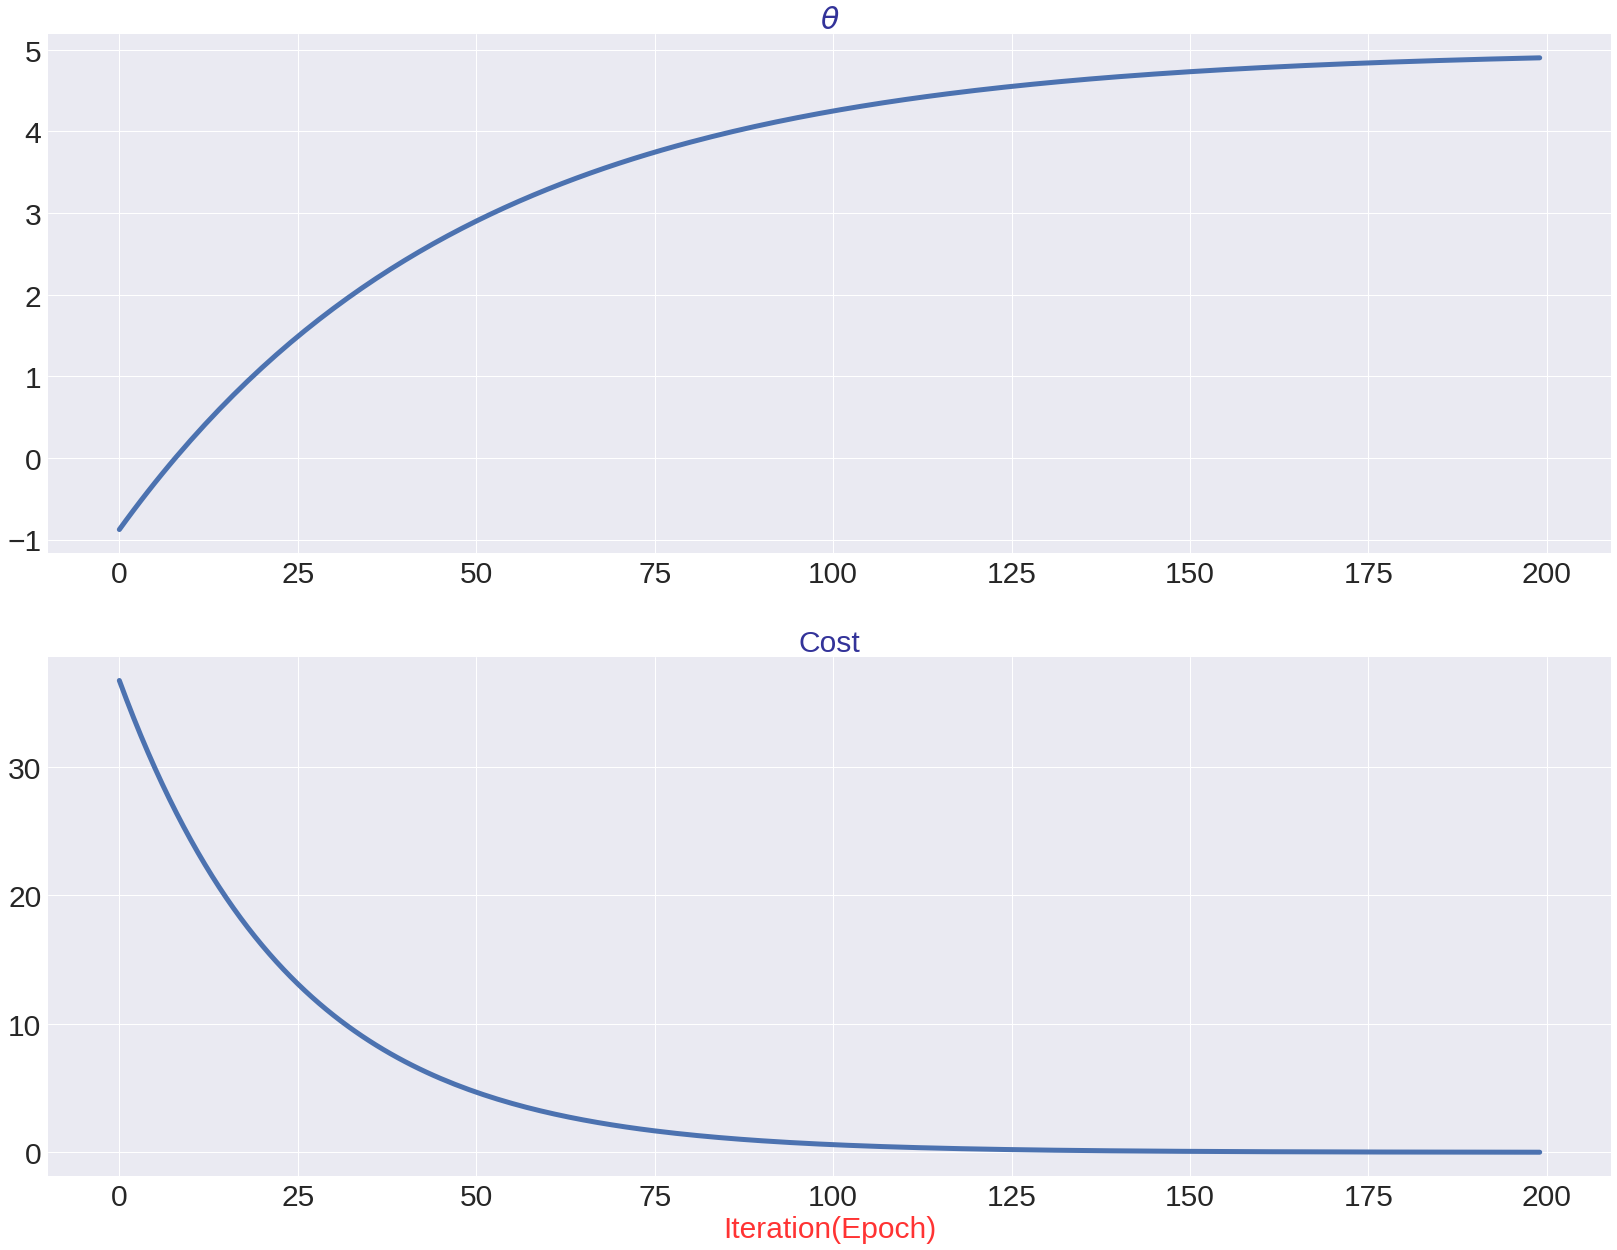

In [22]:
fig, ax = plt.subplots(2,1, figsize=(28, 21))
ax[0].plot(th_list, linewidth = 5)
ax[1].plot(cost_list, linewidth = 5)
title_font = {'size':30, 'alpha':0.8, 'color':'navy'}
label_font = {'size':30, 'alpha':0.8}

ax[0].set_title(r'$\theta$', fontdict = title_font)
ax[1].set_title('Cost', fontdict = title_font)
ax[1].set_xlabel("Iteration(Epoch)", color='red', fontdict = label_font)
ax[0].tick_params(axis='both', which='major', labelsize=30)
ax[1].tick_params(axis='both', which='major', labelsize=30)

# Mini-batch Gradient Descent

### Model/Cost Setting

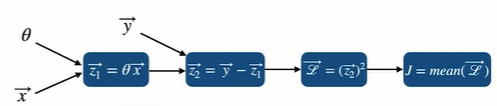

In [23]:
# model part
node1 = mul_node()

# square error loss / MSE cost part
node2 = minus_node()
node3 = square_node()
node4 = mean_node()

## Learning without Replacement

In [26]:
th = -1
lr = 0.01
cost_list, th_list = [], []

batch_size = 16
n_batch = int(np.ceil(len(x_data)/batch_size))

t_iteration = 500 # target iteration
epochs = np.ceil(t_iteration/n_batch).astype(int) # iteration 500을 하기 위한 epoch 수

for epoch in range(epochs):
  for batch_idx in range(n_batch):
    if batch_idx is n_batch-1: # 마지막 배치를 위한 코드
      X = x_data[batch_idx*batch_size :]
      Y = y_data[batch_idx*batch_size :]
    else:
      X = x_data[batch_idx*batch_size : (batch_idx + 1)*batch_size]
      Y = y_data[batch_idx*batch_size : (batch_idx + 1)*batch_size]

    # forward
    Z1 = node1.forward(th, X)
    Z2 = node2.forward(Y, Z1)
    L = node3.forward(Z2)
    J = node4.forward(L)

    # backward
    dL = node4.backward(1)
    dZ2 = node3.backward(dL)
    dY, dZ1 = node2.backward(dZ2)
    dTh, dX = node1.backward(dZ1)

    # update
    th = th - lr*np.sum(dTh)
    th_list.append(th)
    cost_list.append(J)

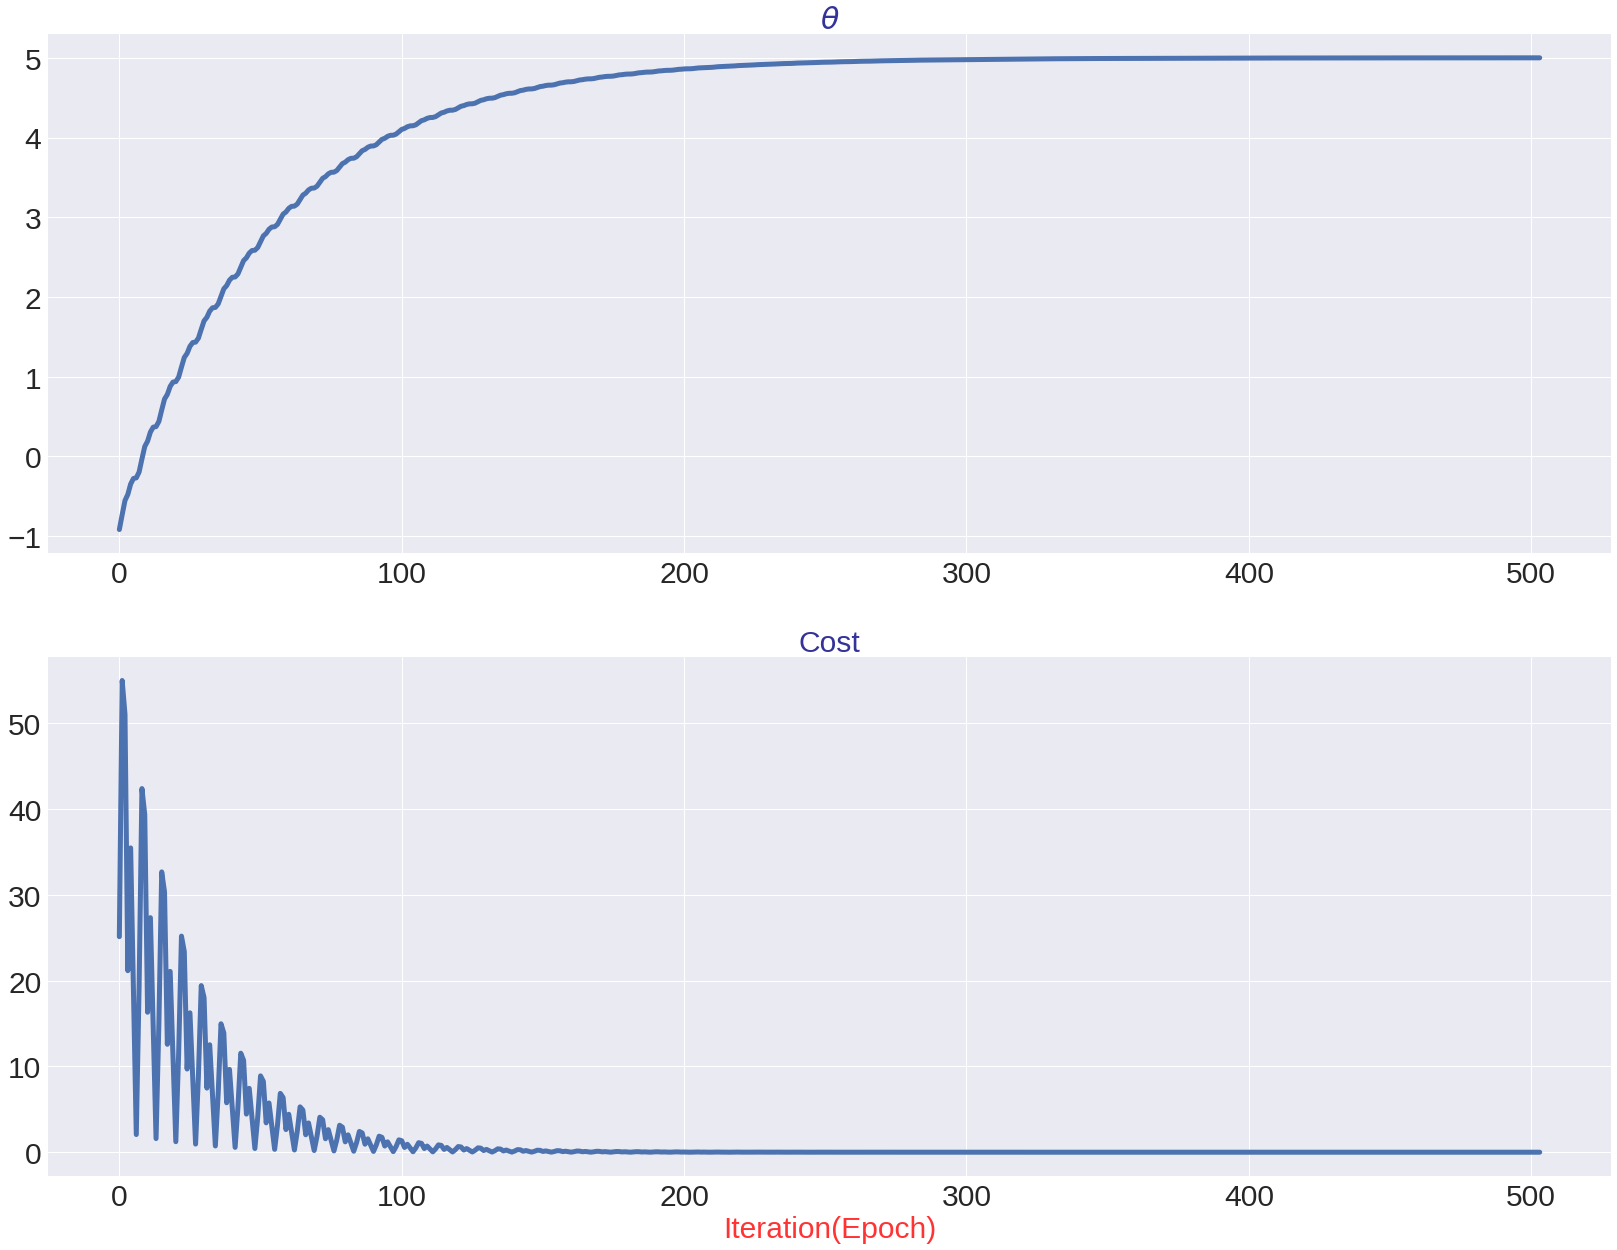

In [27]:
fig, ax = plt.subplots(2,1, figsize=(28, 21))
ax[0].plot(th_list, linewidth = 5)
ax[1].plot(cost_list, linewidth = 5)
title_font = {'size':30, 'alpha':0.8, 'color':'navy'}
label_font = {'size':30, 'alpha':0.8}

ax[0].set_title(r'$\theta$', fontdict = title_font)
ax[1].set_title('Cost', fontdict = title_font)
ax[1].set_xlabel("Iteration(Epoch)", color='red', fontdict = label_font)
ax[0].tick_params(axis='both', which='major', labelsize=30)
ax[1].tick_params(axis='both', which='major', labelsize=30)

## Learning with Replacement

In [31]:
batch_size =32
t_iteration = 500

for _ in range(t_iteration):
  idx_np = np.arange(len(x_data))
  random_idx = np.random.choice(idx_np, batch_size)
  
  X = x_data[random_idx]
  Y = y_data[random_idx]

  # forward
  Z1 = node1.forward(th, X)
  Z2 = node2.forward(Y, Z1)
  L = node3.forward(Z2)
  J = node4.forward(L)

  # backward
  dL = node4.backward(1)
  dZ2 = node3.backward(dL)
  dY, dZ1 = node2.backward(dZ2)
  dTh, dX = node1.backward(dZ1)

  # update
  th = th - lr*np.sum(dTh)
  th_list.append(th)
  cost_list.append(J)

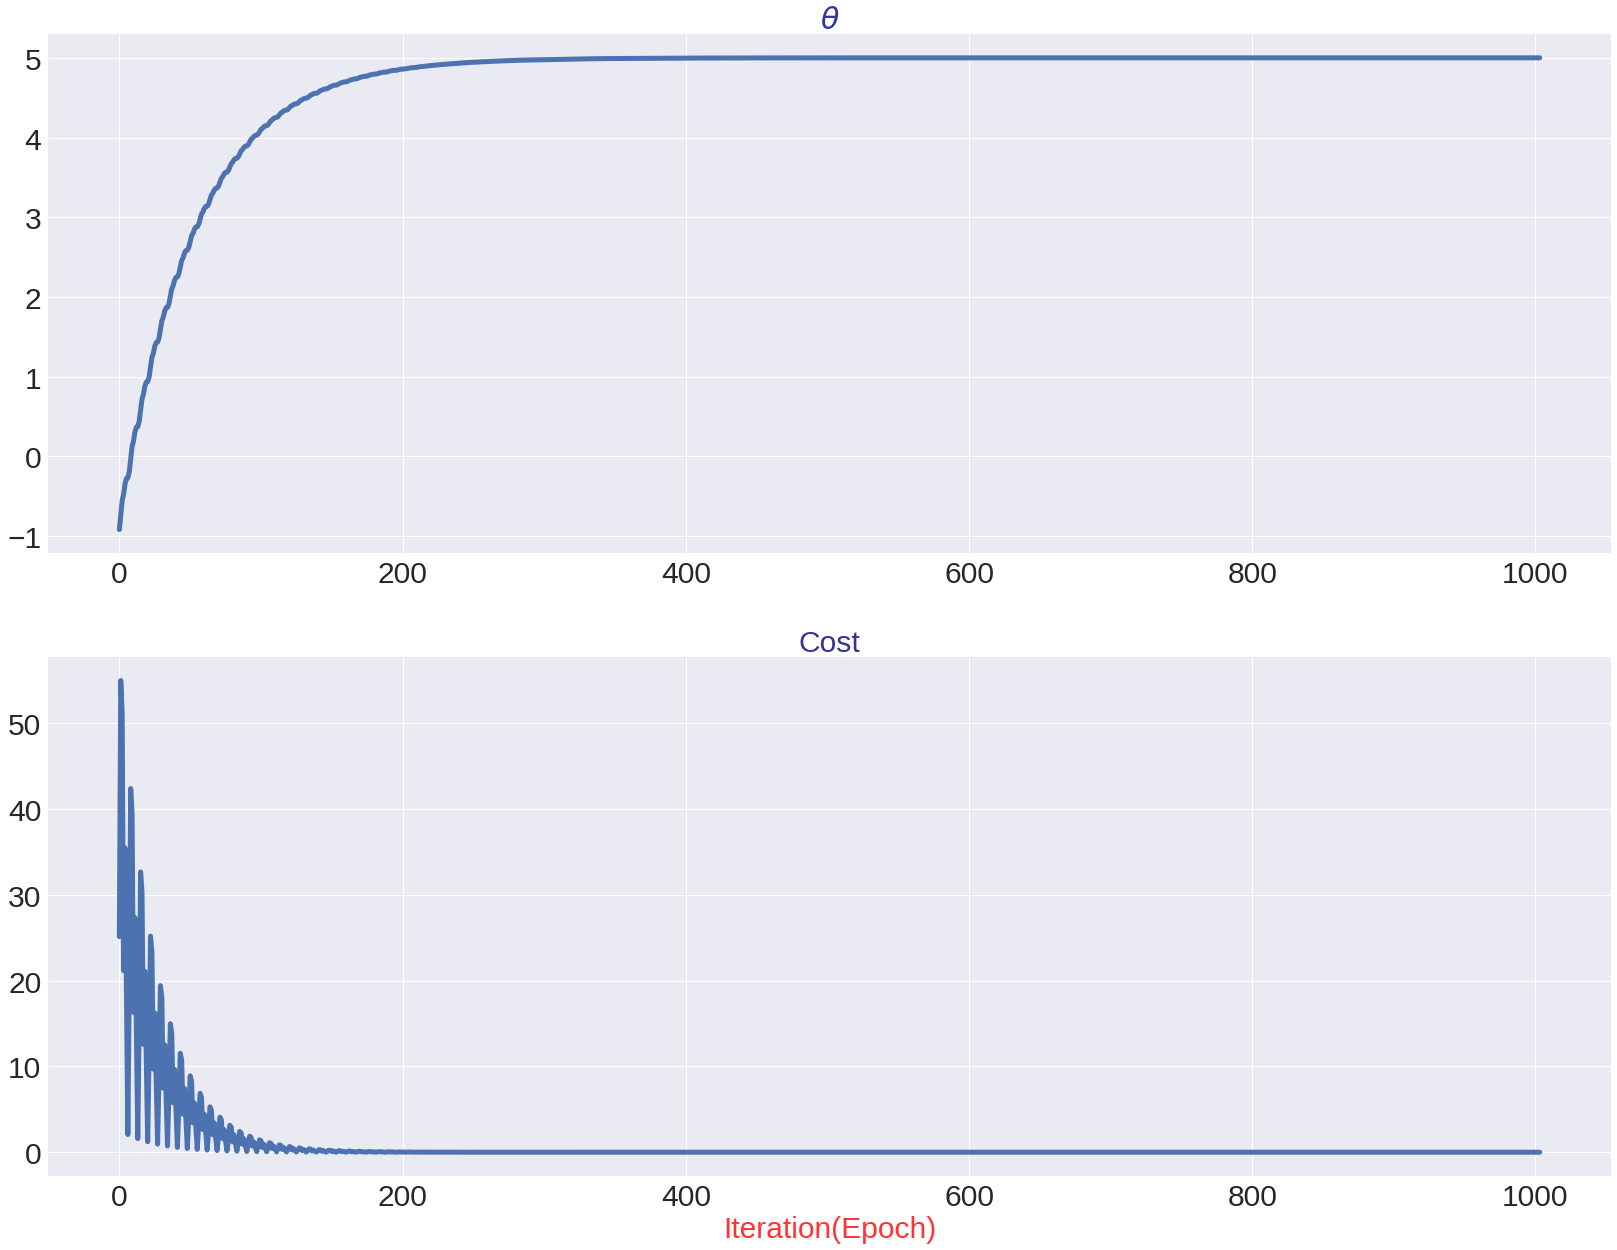

In [32]:
fig, ax = plt.subplots(2,1, figsize=(28, 21))
ax[0].plot(th_list, linewidth = 5)
ax[1].plot(cost_list, linewidth = 5)
title_font = {'size':30, 'alpha':0.8, 'color':'navy'}
label_font = {'size':30, 'alpha':0.8}

ax[0].set_title(r'$\theta$', fontdict = title_font)
ax[1].set_title('Cost', fontdict = title_font)
ax[1].set_xlabel("Iteration(Epoch)", color='red', fontdict = label_font)
ax[0].tick_params(axis='both', which='major', labelsize=30)
ax[1].tick_params(axis='both', which='major', labelsize=30)